In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sns

# Content

* [1.项目背景介绍](#chapter1)
    * [1.1 背景和分析目标](#section_1_1)
    * [1.2 数据局限性](#section_1_2)
    * [1.3 数据字段介绍](#section_1_3)
    
* [2.数据EDA和数据挖掘](#chapter2)
    * [2.1 探索性分析](#section_2_1)
    * [2.2 预制食品和通勤距离之间的关系](#section_2_2)
    * [2.3 收入和喜欢吃的食物类型之间关系](#section_2_3)
    * [2.4 收入和摄入营养之间的关系](#section_2_4)
* [3.建模](#chapter3)
    * [3.1构建用户特征](#section_3_1)

## 1.Tesco Grocery 1.0背景介绍<a class="anchor" id="chapter1"></a>

### 1.1 背景和分析目标<a class="anchor" id="section_1_1"></a>

 2015年，Tesco销售额达到世界第九的零售商伦，该数据集是伦敦地区的411个Tesco的会员购买记录。每条数据以伦敦的Lower Super Output Areas区域为单位。
 每个区域ID代表一个区域。有两个分析目标，①从数据集挖掘出一个规律；②分析食物消耗和收入之间的关系。

### 1.2 数据局限性<a class="anchor" id="section_1_2"></a>

局限一：在伦敦北部的区域Tesco密度比较高，所以北部城市的Tesco渗透率比较高。在我的数据中，表示渗透率的参数我选择以上的。渗透率计算是某一区域Tesco消费者数/该区域总人口，渗透率经过归一化变成0-1之间的数值，在我的分析中，我选取渗透率（归一化后的）高于0.3的lsoa的数据

局限二：数据集不包括其他连锁零售超市，还有在餐馆的食物消费。所以数据集不能反映日常食物消费的整个情况。

### 1.3 数据字段介绍<a class="anchor" id="section_1_3"></a>

In [92]:
dataframe=[]
for root,dirs,files in os.walk('E:/Applied data science/semester2/coursework/Area-level grocery purchases year'):
    for f in files:
        if f.endswith('.csv'):
            df=pd.read_csv(os.path.join(root,f))
            dataframe.append(df)

In [93]:
lsoa_df_org=dataframe[1]

In [94]:
#选取representativeness_norm>0.3的数数据，占losa的0.1%的数据
lsoa_df=lsoa_df_org[lsoa_df_org['representativeness_norm']>0.3]

* area_id:每个区域的Id,是唯一的区域标识
* weight:某一区域所消耗的一件食物的平均重量（克）
* volume:某一区域所消耗的一件饮料的的平均体积（公升）
* fat,saturate,salt,sugar,carb,fibre,protein,alcohol:在某一区域一件食物中包含的8种营养的各自的重量（克）
* energy_fat,energy_sugar,energy_protein,energy_carb,energy_fiber,energy_alcohol:在某一区域一件食物中来自8种营养的各种的能量（卡路里）
* energy_tot:某一区域所消耗的一件食物所包含的平均能量（卡路里）
* f_energy_fat，f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol：在某一区域一件食物中来自7种营养的各自的占比
* energy_density:某一区域所消耗的平均食物的每一克所含有的能量（卡路里）
* h_nutrients_weight_norm:某一区域的8种营养的重量的归一化的熵
* h_nutrients_calories_norm:某一区域的来自8种营养的能量的归一化的熵
* f_beer,f_dairy,f_eggs,f_fats_oils,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,\
f_sauces,f_soft_drinks,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine：某一区域17种食物种类数量的占比
* f_dairy_weight,f_eggs_weight,f_fats_oils_weight,f_fish_weight,f_fruit_veg_weight,f_grains_weight,f_meat_red_weight,f_poultry_weight,\
f_readymade_weight,f_sauces_weight,f_sweets_weight:某一区域12种食物种类重量的占比
* h_items_norm：17种类食物的归一化的熵
* h_items_weight_norm：12种类食物重量的的归一化的熵
* representativeness_norm：归一化渗透率
* transaction_days：有交易的日期天数
* num_transactions: 2015年,居住在该区域的会员购买的食物的的总数

## 2.数据EDA和数据挖掘<a class="anchor" id="chapter2"></a>

### 2.1 探索性数据分析<a class="anchor" id="section_2_1"></a>

In [5]:
lsoa_df=lsoa_df.dropna()
#样本有749个地区
lsoa_df['area_id'].nunique()

749

### 看地区有没有非常不一样的Tesco食物购买消费习惯

横轴是该地区的均值，y轴是该地区的中位数
* 因为alcohol_perc50和energy_alcohol_perc50的值都是0,是无效数据，这两个特征不在讨论范围
* 从下面的散点图来看，weight是所有特征中均值和中位数差别最小的，
* 大部分地区平均食物含有脂肪的质量的中位数集中分布在1.5-2.5之间，均值在8-10之间；糖类的中位数集中分布在在3-4.75之间，均值在8-11之间，糖类和脂肪的中位数和均值之间相差比其他的5中营养成分（饱和脂肪酸，盐，膳食纤维，蛋白质，碳水）更加的大，也就是方差大，也就是地区购买的所有食物中，大部分的食物的糖分和脂肪分别分布在0-5和1-7之间，但是仍然购买一些糖分和脂肪含量特别高的食物。且几乎所有的地区都是这样的趋势。


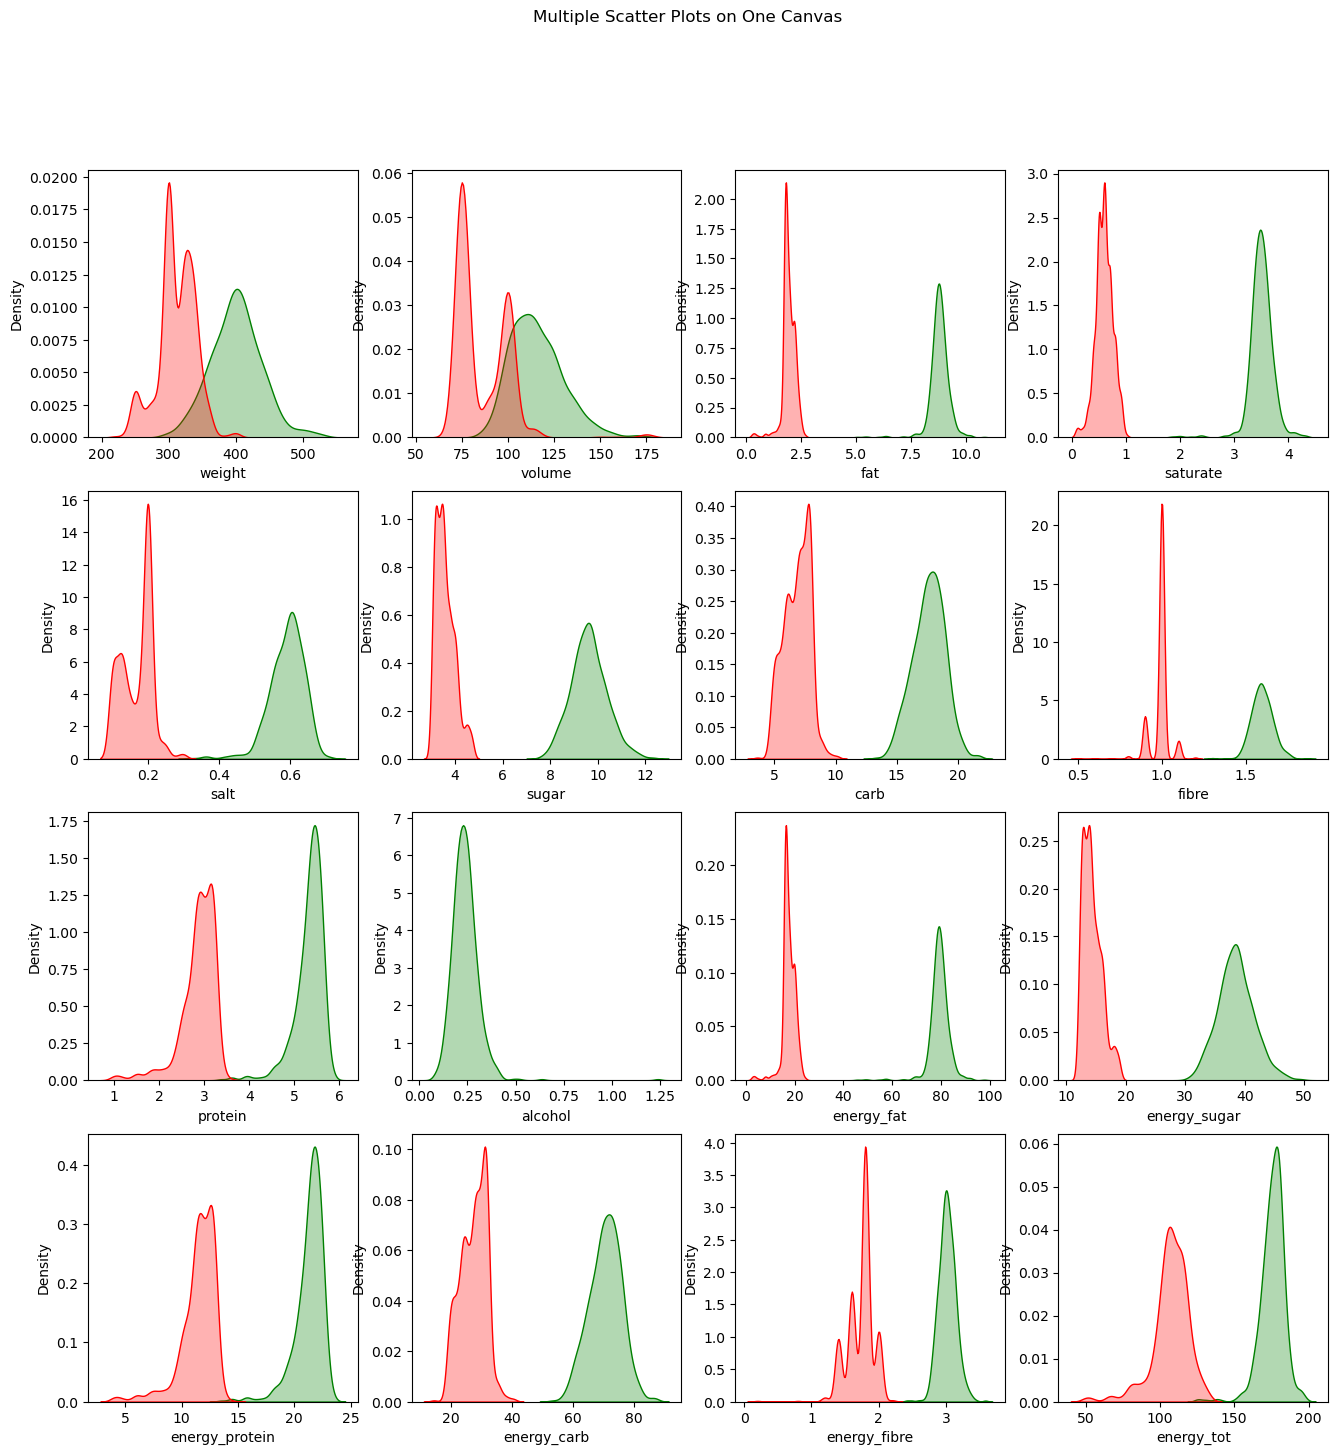

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, axs = plt.subplots(4, 4, figsize=(16,16))
point_size = 5 # 点的大小
point_alpha = 0.3  # 点的透明度
x_label_fontsize=9
y_label_fontsize=9
columns_to_plot = {'weight':["weight_perc50",0,0], 'volume':['volume_perc50',0,1], 'fat':['fat_perc50',0,2], 'saturate':['saturate_perc50',0,3],
                   'salt':['salt_perc50',1,0], 'sugar':['sugar_perc50',1,1], 'carb':['carb_perc50',1,2], 'fibre':['fibre_perc50',1,3], \
                   'protein':['protein_perc50',2,0], 'alcohol':['alcohol_perc50',2,1], 'energy_fat':['energy_fat_perc50',2,2], \
                   'energy_sugar':['energy_sugar_perc50',2,3], 'energy_protein':["energy_protein_perc50",3,0],'energy_carb':['energy_carb_perc50',3,1],\
                   'energy_fibre':['energy_fibre_perc50',3,2], 'energy_tot':['energy_tot_perc50',3,3]}

for key,values in columns_to_plot.items():
    sns.kdeplot(lsoa_df[key], ax=axs[values[1],values[2]],shade=True, alpha=0.3, label=key, color='green',warn_singular=False)
    sns.kdeplot(lsoa_df[values[0]], ax=axs[values[1],values[2]],shade=True, alpha=0.3, label=values[0], color='red',warn_singular=False)

fig.suptitle('Multiple Scatter Plots on One Canvas')

plt.show()


有一些地区标准差很高在600-1000之间

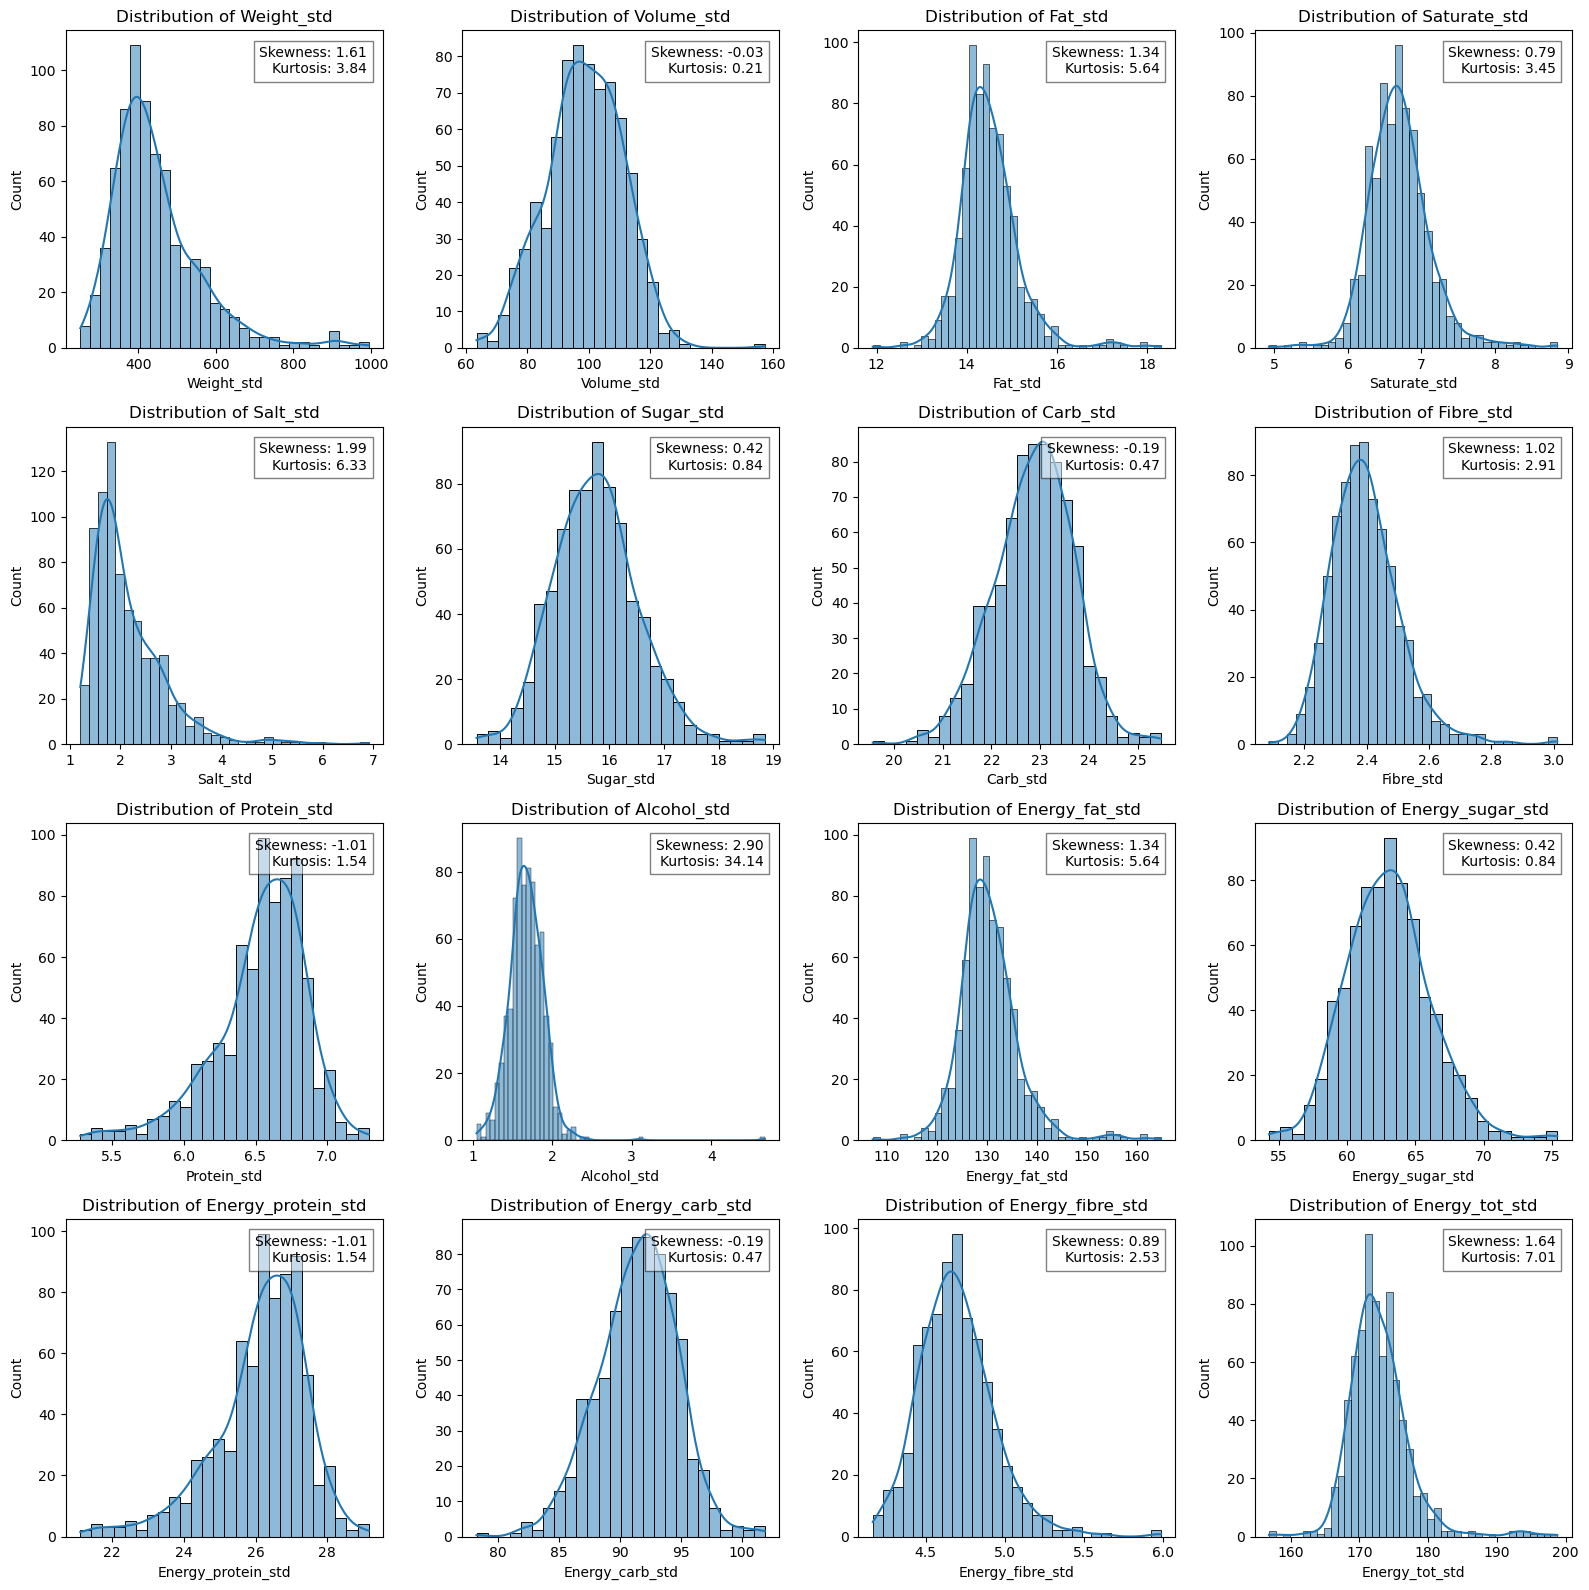

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, kurtosis
warnings.simplefilter(action='ignore', category=FutureWarning)
columns_to_plot = {'weight_std':[0,0], 'volume_std':[0,1], 'fat_std':[0,2], 'saturate_std':[0,3], 'salt_std':[1,0], 'sugar_std':[1,1], \
                   'carb_std':[1,2], 'fibre_std':[1,3], 'protein_std':[2,0], 'alcohol_std':[2,1], 'energy_fat_std':[2,2], \
                   'energy_sugar_std':[2,3], 'energy_protein_std':[3,0], 'energy_carb_std':[3,1], 'energy_fibre_std':[3,2],\
                   'energy_tot_std':[3,3]}
# 创建一个画布，设置子图的排列
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
lsoa_df=lsoa_df.replace([np.inf, -np.inf], np.nan)

# 循环遍历每个列，并绘制对应的直方图
for key,(row,col) in columns_to_plot.items():
            sns.histplot(lsoa_df[key], ax=axs[row,col], kde=True)  # 绘制直方图
            axs[row, col].set_title(f'Distribution of {key.capitalize()}')  # 添加子图标题
            axs[row, col].set_xlabel(key.capitalize())  # 添加 x 轴标签
            skewness = skew(lsoa_df[key])
            kurt = kurtosis(lsoa_df[key])
            axs[row, col].text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}',
                       verticalalignment='top', horizontalalignment='right',\
                       transform=axs[row, col].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()


从下面的分布看出来，每个地区平均食物中，来自7种营养的能量供应占比的供应顺序是fat,carb,sugar,saturate,protein,fibre,alcohol，也就是所有地区最主要的能量的供应的来源是脂肪和碳水。能量供应在其他5种营养中达到了35%-51%占比；来自纤维和酒精的能量占比是最小的，只占到了1%-5%

<AxesSubplot:xlabel='f_energy_fat', ylabel='Density'>

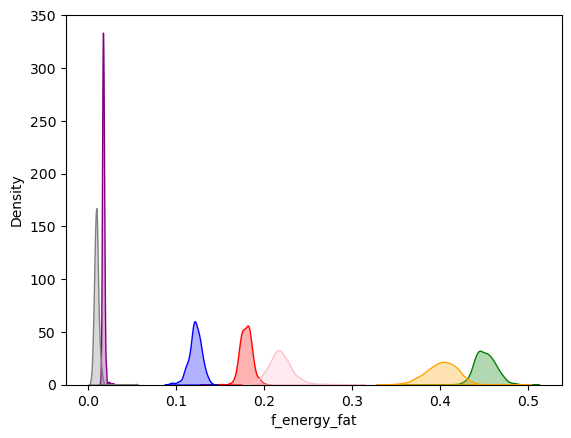

In [8]:
energy_nutrient=['f_energy_fat','f_energy_saturate','f_energy_sugar','f_energy_protein',\
                 'f_energy_carb','f_energy_fibre','f_energy_alcohol']
sns.kdeplot(lsoa_df[energy_nutrient[0]],shade=True, alpha=0.3, color='green',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[1]],shade=True, alpha=0.3, color='red',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[2]],shade=True, alpha=0.3, label=key, color='pink',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[3]], shade=True, alpha=0.3, label=values[0], color='blue',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[4]], shade=True, alpha=0.3, label=key, color='orange',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[5]], shade=True, alpha=0.3, label=values[0], color='purple',warn_singular=False)
sns.kdeplot(lsoa_df[energy_nutrient[6]], shade=True, alpha=0.3, label=values[0], color='grey',warn_singular=False)
#fat,carb,sugar,saturate,protein,fibre,alcohol

#### 对于所有的地区来说，平均食物的每一克所含有的能量基本服从正态分布，几乎98%的地区每一克食物能量供应都在0.38-0.55卡路里/g之间。

Text(-5, -10, 'Skewness: 0.13\nKurtosis: 2.94')

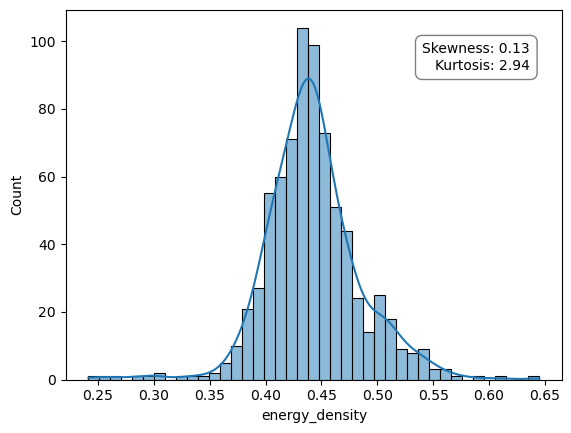

In [9]:
plot=sns.histplot(lsoa_df['energy_density'], kde=True) 
skewness = skew(lsoa_df['energy_density'])
kurt = kurtosis(lsoa_df['energy_density'])
plot.annotate(f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}',
              xy=(0.95, 0.95), xycoords='axes fraction',
              xytext=(-5, -10), textcoords='offset points',
              fontsize=10, ha='right', va='top',
              bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

#### 每一克食物能量供应比较小的地区的ID （小于0.3卡路里/g）

In [10]:
lsoa_df[lsoa_df['energy_density']<0.3]['area_id']

210    E01000215
212    E01000217
213    E01000218
215    E01000220
231    E01000236
Name: area_id, dtype: object

#### 每一克食物能量供应比较大的地区的ID（大于0.6卡路里/g）

In [11]:
lsoa_df[lsoa_df['energy_density']>0.6]['area_id']

686    E01000702
689    E01000705
Name: area_id, dtype: object

#### 熵越低，能量的来源更加多样性.

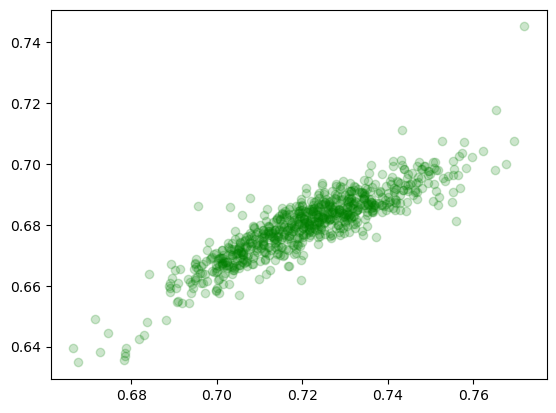

In [12]:
plt.scatter(x=lsoa_df['h_nutrients_weight_norm'],y=lsoa_df['h_nutrients_calories_norm'],alpha=0.2,color='green')

#### 熵相对其他点偏小的区域（熵小于0.64）

In [13]:
lsoa_df[lsoa_df['h_nutrients_calories_norm']<0.64]['area_id']

3414    E01003489
3484    E01003562
3487    E01003565
3488    E01003566
3490    E01003568
3491    E01003569
3495    E01003573
Name: area_id, dtype: object

In [14]:
f_food_catergrogy=lsoa_df[['f_beer','f_dairy','f_eggs','f_fats_oils',\
                           'f_fish','f_fruit_veg','f_grains','f_meat_red','f_poultry','f_readymade',\
                           'f_sauces','f_soft_drinks','f_spirits','f_sweets','f_tea_coffee','f_water','f_wine']].describe()
#c.iloc[1]

#### 由于各个地区食物消耗种类的占比分布基本都是正态分布，所以取所有区域的食物种类占比的平均值；从下面的图中可以看到，749个区域的平均食物种类占比中，水果蔬菜占比远远高于其他食物种类，其次是甜食，谷物类和奶制品

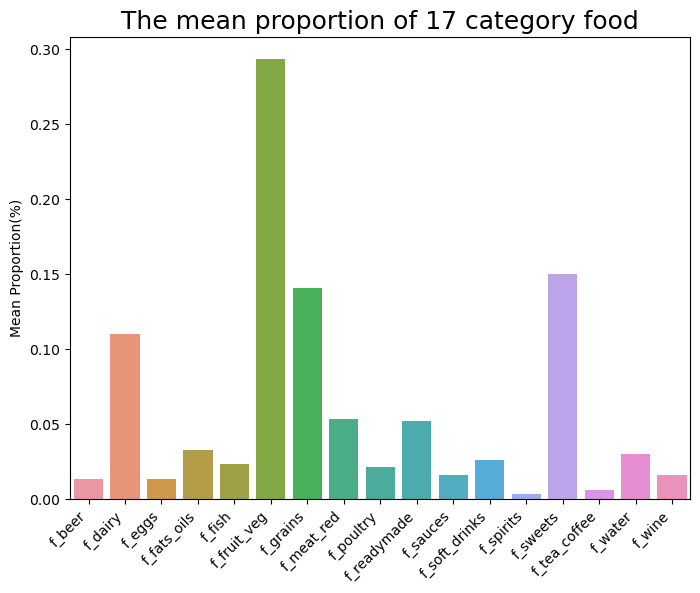

In [15]:
import warnings
warnings.filterwarnings("ignore")
#sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
barplot=sns.barplot(x=f_food_catergrogy.columns.tolist(),y=f_food_catergrogy.loc['mean'])
barplot.set_title("The mean proportion of 17 category food",fontsize=18)
barplot.set_ylabel('Mean Proportion(%)')
labels=barplot.get_xticklabels()
barplot=barplot.set_xticklabels(labels=labels,rotation=45, horizontalalignment='right')

#### 从下图中看出来，大部分地区食物种类的熵(entropy)都是？熵开始下降的是从?开始，从？之后熵都比其他高，图中显示出现了两个拐点

In [16]:
h_items=lsoa_df['h_items_norm'].sort_values()

In [17]:
plt.figure(figsize=(300,120))
barplot_h=sns.barplot(x=list(range(len(h_items))),y=h_items)
#barplot_h.set_title("The mean proportion of 17 category food",fontsize=30)
plt.yticks(fontsize=350)
plt.ylabel('h_item_norm',fontsize=350)

Text(0, 0.5, 'h_item_norm')

### 2.2 预制食品和通勤距离之间的关系<a class="anchor" id="section_2_2"></a>

地图来自https://p-ada-wan.github.io/ 从地图显示，在伦敦大部分郊区食用预制食品的比例明显高于城市中间地区，猜测是因为通勤距离导致郊区的居民食用更多的预制食物。现在有一份Lsoa的通勤距离的数据，根据这个

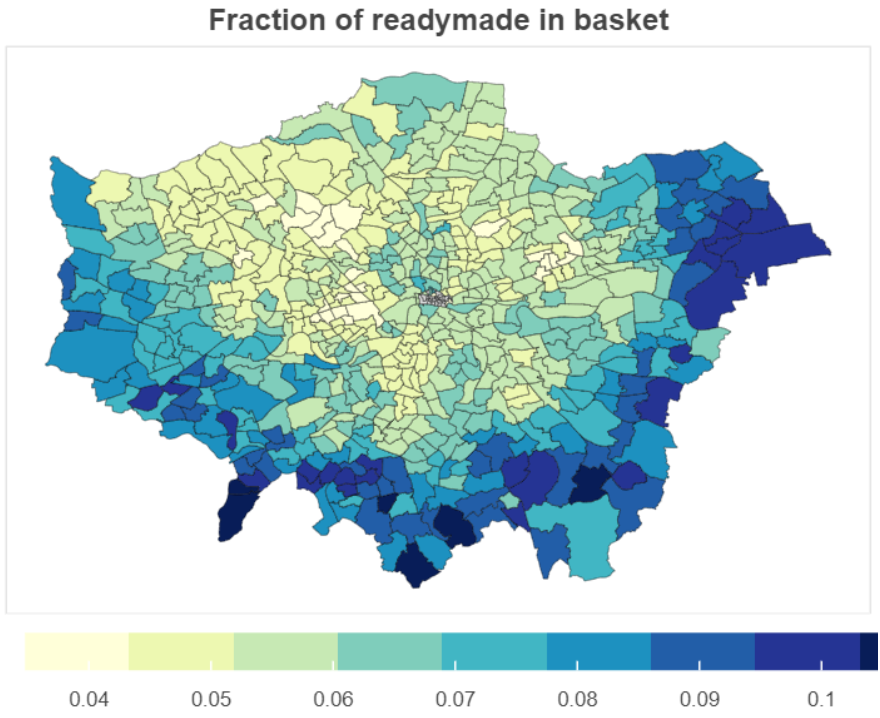

In [19]:
Travel_distance_lsoa=pd.read_excel('E:/Applied data science/semester2/coursework/lsoa_distance traveled to work.xlsx',\
                                   sheet_name='2011_readymade')
Travel_distance_ward=pd.read_excel('E:/Applied data science/semester2/coursework/Ward_distance traveled to work.xlsx',\
                                   sheet_name='2011_readymade')

In [189]:
lsoa_dis_df=dataframe[1][['f_readymade','area_id']].merge(Travel_distance_lsoa,on="area_id",how='left').dropna().reset_index(drop=True)
lsoa_dis_df['f_2km to less than 10km']=lsoa_dis_df['f_2km to less than 5km']+lsoa_dis_df['f_5km to less than 10km']
lsoa_dis_df_spearman=lsoa_dis_df.drop(columns=['area_id','local authority name','f_2km to less than 5km','f_5km to less than 10km'])
Ward_dis_df=dataframe[3][['f_readymade','area_id']].merge(Travel_distance_ward,on="area_id",how='left').dropna().reset_index(drop=True)
Ward_dis_df=Ward_dis_df.drop(columns=['area_id','local authority name','ward name'])


In [190]:
lsoa_dis_corr=lsoa_dis_df_spearman.corr(method="pearson").drop(index='f_readymade')
lsoa_dis_corr

,f_readymade,f_Less than 2km,f_10km to less than 20km,f_20km to less than 30km,f_30km to less than 40km,f_40km to less than 60km,f_60km and over,f_Work mainly at or from home,f_2km to less than 10km
f_Less than 2km,0.010383,1.000000,-0.324404,-0.101357,-0.120154,-0.018014,-0.537343,-0.050654,-0.088351
f_10km to less than 20km,0.189013,-0.324404,1.000000,0.104007,0.338672,0.139578,0.122980,-0.068861,-0.795504
f_20km to less than 30km,0.474758,-0.101357,0.104007,1.000000,0.516605,0.232228,0.083415,-0.071203,-0.434564
f_30km to less than 40km,0.375804,-0.120154,0.338672,0.516605,1.000000,0.262050,0.093610,-0.100274,-0.454405
f_40km to less than 60km,0.144920,-0.018014,0.139578,0.232228,0.262050,1.000000,0.043363,-0.050368,-0.217230
f_60km and over,-0.028339,-0.537343,0.122980,0.083415,0.093610,0.043363,1.000000,0.030225,0.056249
f_Work mainly at or from home,-0.127170,-0.050654,-0.068861,-0.071203,-0.100274,-0.050368,0.030225,1.000000,-0.058856
f_2km to less than 10km,-0.303938,-0.088351,-0.795504,-0.434564,-0.454405,-0.217230,0.056249,-0.058856,1.000000


In [191]:
Ward_dis_corr=Ward_dis_df.corr(method='spearman').drop(index='f_readymade')

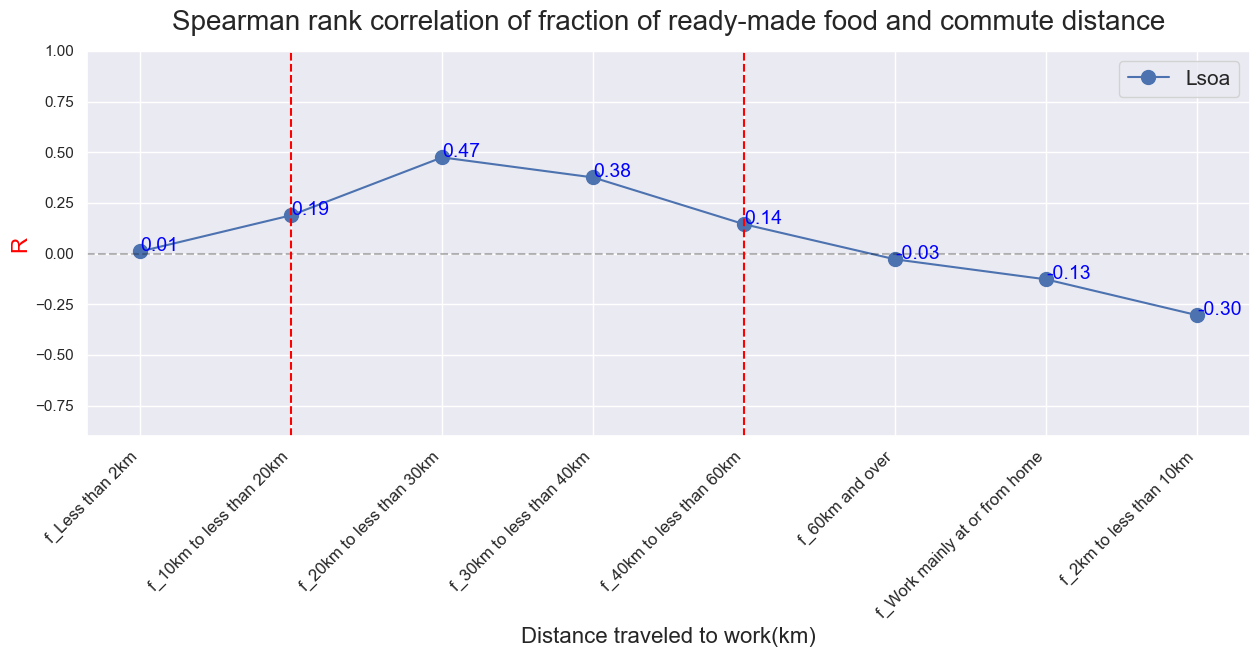

In [192]:
import math
sns.set(context='notebook', style='darkgrid', 
palette='deep', font='sans-serif', font_scale=1, 
color_codes=True, rc=None)

fig = plt.figure(figsize=(15,5)) 
plt.plot(lsoa_dis_corr.columns[1:9],lsoa_dis_corr["f_readymade"],marker="o",markersize=10,label="Lsoa")
#plt.plot(Ward_dis_corr.columns[1:9],Ward_dis_corr["f_readymade"],marker="*",markersize=10,label="Lsoa")

plt.xticks(rotation=45, fontsize=12,ha="right")
plt.xlabel("Distance traveled to work(km)",fontsize=16)
plt.ylabel("R",fontsize=16,color="red")
plt.title( "Spearman rank correlation of fraction of ready-made food and commute distance",fontsize=20,pad=15)
plt.ylim(-0.9, 1)
plt.axhline(y=0, color='k',linestyle="--",alpha=0.3)

plt.axvline(x="f_10km to less than 20km", color='red',linestyle="--")
plt.axvline(x="f_40km to less than 60km", color='red',linestyle="--")
for a, b in zip(lsoa_dis_corr.columns[1:9],lsoa_dis_corr["f_readymade"]):
    plt.text(a,b,'%.2f' % b,fontsize=14,color="blue")
    
#for a, b in zip(Ward_dis_corr.columns[1:10],Ward_dis_corr["f_readymade"]):
    #plt.text(a,b,'%.2f' % b,fontsize=15,color="green", verticalalignment="bottom")
    
plt.legend(fontsize=15)

#### 拟合一个OLS模型来观察各种通勤距离对食用预制实物的影响

In [260]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm

x=lsoa_dis_df[['f_Less than 2km','f_2km to less than 10km','f_20km to less than 30km',\
             'f_30km to less than 40km','f_40km to less than 60km']]
y=lsoa_dis_df['f_readymade'].array.reshape(-1, 1)
X=sm.add_constant(x)

In [261]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=666,train_size=0.8)

In [262]:
model=sm.OLS(y_train,x_train).fit()

#### 计算模型的预测结果，发现模型的预测结果一般

In [263]:
y_pred=model.predict(x_test)

In [264]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)
print("coef:",coef)
print("R2:",r2)
print("RMSE:" ,rmse)

coef: [[-0.02158601  0.00964508  0.1490699   0.39031326 -0.03278236]]
R2: 0.25083847985647545
RMSE: 0.016841791974892602


#### 计算系数的置信区间（显著水平95%），发现除了f_40km to less than 60km对食用预制品没有显著效果，其他的通勤距离都有统计显著性. 将变量10km-20km的通勤距离去掉是因为2km-10km之间具有非常强的线性负相关（pearson cofe 达到了0.8）。模型不能在两个高度相关的变量之间分配准确的解释能力，导致系数方向和大小不稳定。
#### 当我同时加入两个变量在模型的时候，两个变量的系数都变成了正值，这明显和上面的皮尔逊相关系数的结果相反，从上面皮尔逊相关系数的中可以看到2km-10km和食用预制食物之间的关系是负相关在。所以去掉其中一个变量使得OLS模型更具有鲁棒性

从下面的系数的置信区间可以看出来，40km-60km之间的通勤距离对食物中预制食物的比例没有明显的影响，影响最大的是20km-30km,30km-40km的因素，而且是正相关，也就是通勤距离越远，预制食物吃的越多。但是通勤距离在2km-10km产生的是相反的影响，也可以理解为通勤距离在2km-10km之间的人选择更少的吃预制食物。

In [265]:
conf=model.conf_int(alpha=0.05)
conf['coef']=model.params
print("Confidence intervals:")
print(conf)

Confidence intervals:
                                 0         1      coef
const                     0.050515  0.057200  0.053858
f_Less than 2km           0.010557  0.029768  0.020163
f_2km to less than 10km  -0.015715 -0.005394 -0.010555
f_20km to less than 30km  0.139629  0.167420  0.153525
f_30km to less than 40km  0.366170  0.586916  0.476543
f_40km to less than 60km -0.113891  0.176608  0.031359


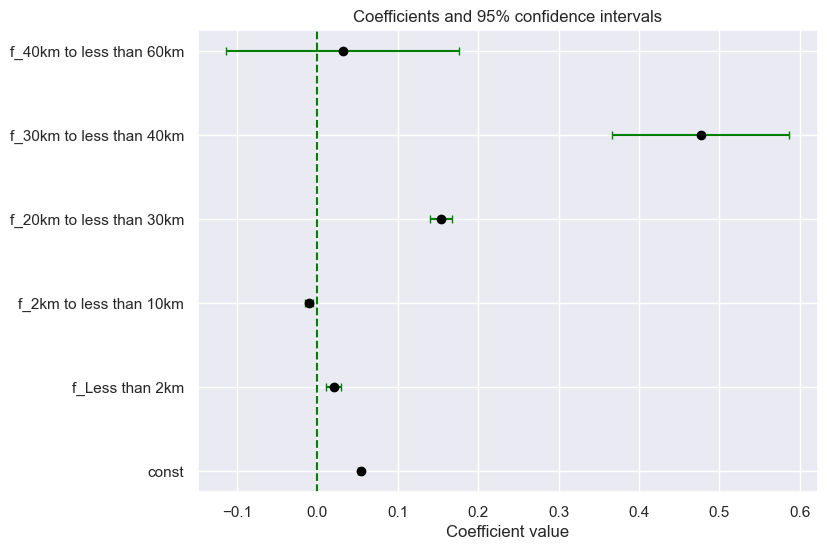

In [266]:
plt.figure(figsize=(8, 6))
plt.errorbar(conf['coef'], conf.index, xerr=(conf[1] - conf[0]) / 2, fmt='o', color='black', ecolor='green', capsize=3)
plt.axvline(x=0, linestyle='--', color='green')
plt.xlabel('Coefficient value')
plt.title('Coefficients and 95% confidence intervals')
plt.show()

### 2.3 收入和消耗的食物类型之间关系 <a class="anchor" id="section_2_3"></a>

探索伦敦lsoa区域的收入的变化规律, 数据来源于data.london.gov.uk公布的官方统计数据，从下面的图可以看到伦敦Lsoa平均收入在过去十二年（2001-2012年）都呈现出逐渐上升的趋势，这样的上升是因为通货膨胀。数据统计只到2012年，按照这样过去十年的趋势，到2015年的时候，每个区域的增长幅度会是相似的，所以地区之间的收入分布在2015年预测会和过去基本一致（地区的收入之间相对变化在短时间内不会产生很大的改变），这样我用2012年的收入来和2015年Tesco数据做分析，依然是合理的.

In [12]:
income_lsoa=pd.read_csv('E:/Applied data science/semester2/coursework/Income/income-estimates-lsoa.csv',sep=',',encoding = 'unicode_escape')
income_ward=pd.read_csv('E:/Applied data science/semester2/coursework/Income/income-estimates-wards.csv',sep=',',encoding = 'unicode_escape')

In [13]:
income_lsoa=income_lsoa.rename(columns={"Code":"area_id"})
income_ward=income_ward.rename(columns={"Code":"area_id"})

In [14]:
def clean_income_data(value):
    return int(value.replace("£",'').replace(',',''))

In [15]:
def clean_df_mean(df):
    for i in range(4,16):
        df.iloc[:,i]=df.iloc[:,i].apply(clean_income_data)
        
def clean_df_median(df):
    for i in range(16,28):
        df.iloc[:,i]=df.iloc[:,i].apply(clean_income_data)

In [16]:
clean_df_mean(income_lsoa)
clean_df_median(income_lsoa)
clean_df_mean(income_ward)
clean_df_median(income_ward)

In [17]:
plot_income=income_lsoa.sample(frac=0.006)

Text(0, 0.5, 'Median')

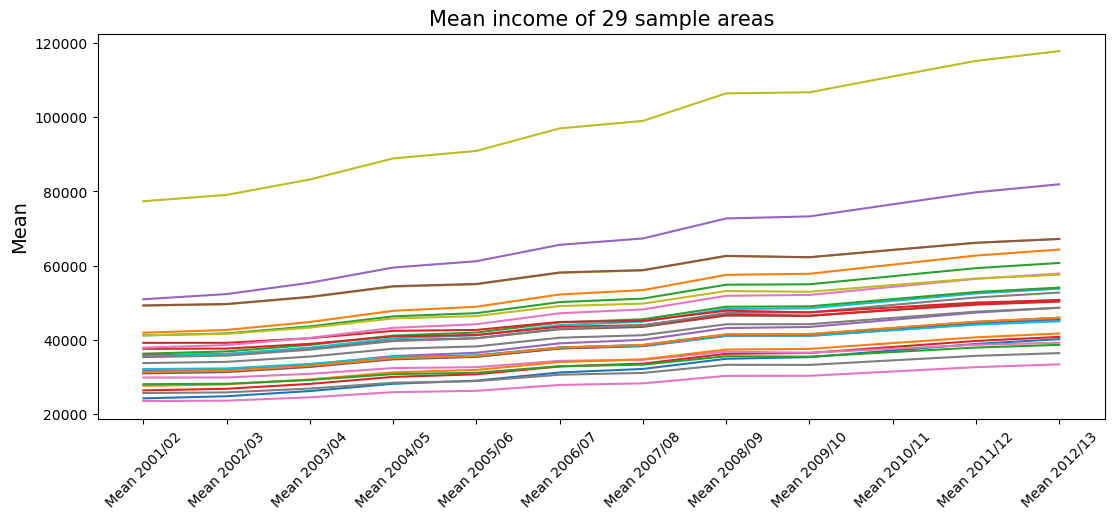

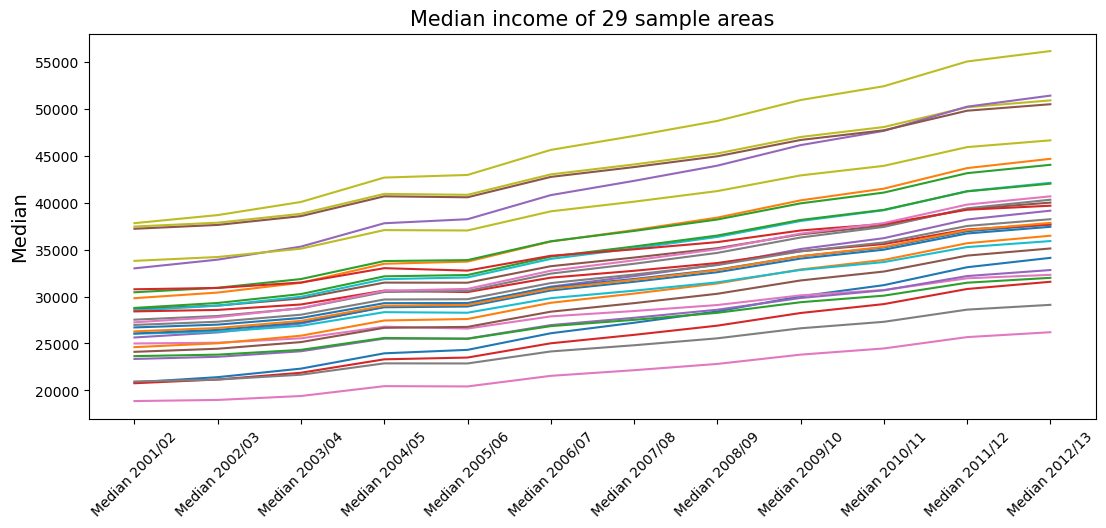

In [18]:
#收入均值
fig=plt.figure(figsize=(13,5))
for i in range(len(plot_income)):
    plt.plot(plot_income.columns[4:16],plot_income.iloc[i,4:16])
plt.xticks(rotation=45)
plt.title("Mean income of 29 sample areas",fontsize=15)
plt.ylabel("Mean",fontsize=14)
#收入中位数
fig=plt.figure(figsize=(13,5))
for j in range(len(plot_income)):
    plt.plot(plot_income.columns[16:28],plot_income.iloc[j,16:28])
plt.xticks(rotation=45)
plt.title("Median income of 29 sample areas",fontsize=15)
plt.ylabel("Median",fontsize=14)

In [43]:
colname_income=['area_id','Mean 2012/13']
colname_category=['area_id']+list(lsoa_df.columns[157:174])+['h_items_norm']

In [44]:
income_corr_lsoa_df=income_lsoa[colname_income]
income_corr_ward_df=income_ward[colname_income]

In [45]:
food_category_lsoa_df=lsoa_df[colname_category].merge(income_corr_lsoa_df,on='area_id',how="left").drop('area_id',axis=1).dropna()
food_category_ward_df=dataframe[3][colname_category].merge(income_corr_ward_df,on='area_id',how='left').drop('area_id',axis=1).dropna()

In [46]:
spearman_food_lsoa=food_category_lsoa_df.corr(method='spearman').drop('Mean 2012/13',axis=0)
spearman_food_ward=food_category_ward_df.corr(method='spearman').drop('Mean 2012/13',axis=0)#横轴

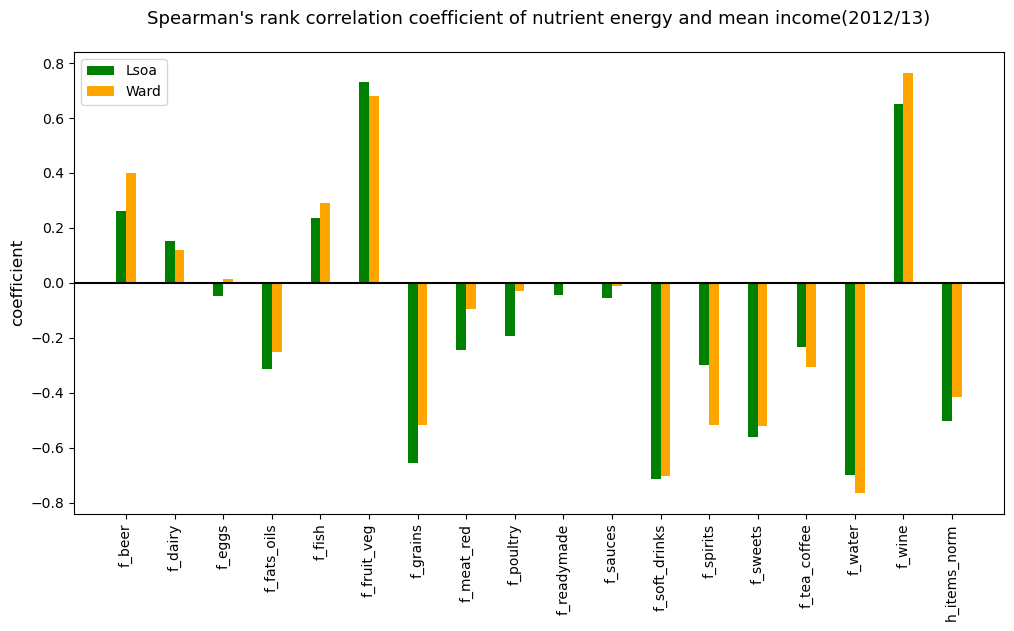

In [79]:
plt.figure(figsize=(12,6))
labels=list(spearman_food_lsoa.columns[0:len(spearman_food_lsoa.columns)-1])

loc=np.arange(len(labels))
bar=0.2

plt.bar(loc,spearman_food_lsoa["Mean 2012/13"],bar,color='green',label='Lsoa')
plt.bar([j+bar for j in loc],spearman_food_ward['Mean 2012/13'],bar,color='orange',label="Ward")

plt.axhline(y=0,color='black')
plt.xticks([i+bar/2 for i in loc],labels,rotation=90)
plt.ylabel('coefficient',fontsize=12)
plt.title( "Spearman's rank correlation coefficient of nutrient energy and mean income(2012/13)",fontsize=13,pad=20)
plt.legend(loc='upper left')

### 2.4 收入和摄入营养之间的关系 <a class="anchor" id="section_2_4"></a>

In [53]:
colnames=["area_id"]+list(lsoa_df.columns[145:152])+['h_nutrients_calories_norm']

In [54]:
energy_nutrient_lsoa_df=lsoa_df[colnames].merge(income_corr_lsoa_df,on='area_id',how='left').drop(['area_id'],axis=1).dropna()
energy_nutrient_ward_df=dataframe[3][colnames].merge(income_corr_ward_df,on='area_id',how='left').drop(['area_id'],axis=1).dropna()

In [55]:
spearman_lsoa=energy_nutrient_lsoa_df.corr(method='spearman').drop('Mean 2012/13',axis=0)
spearman_ward=energy_nutrient_ward_df.corr(method='spearman').drop('Mean 2012/13',axis=0)

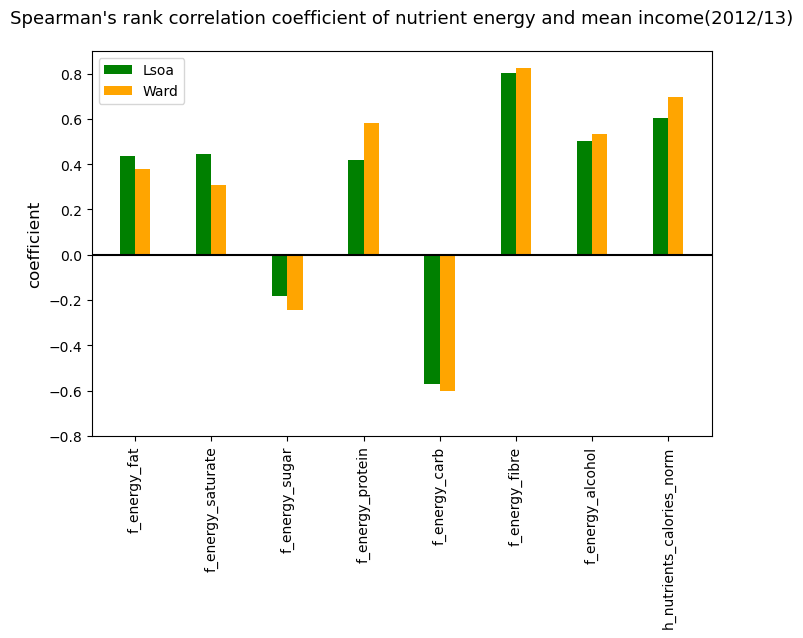

In [80]:
labels=list(spearman_lsoa.columns[0:len(spearman_lsoa)])
plt.figure(figsize=(8,5))

loc=np.arange(len(labels))
bar=0.2

plt.bar(loc,spearman_lsoa['Mean 2012/13'],bar,label='Lsoa',color='green')
plt.bar([j+bar for j in loc],spearman_ward['Mean 2012/13'],bar,label="Ward",color='orange')
plt.axhline(y=0,color='black')
plt.xticks([i+bar/2 for i in loc], labels,rotation=90)
plt.ylabel('coefficient',fontsize=12)
plt.title( "Spearman's rank correlation coefficient of nutrient energy and mean income(2012/13)",fontsize=13,pad=20)
plt.ylim(-0.8,0.9)
plt.legend(loc='upper left')

## 3.建模<a class="anchor" id="chapter3"></a>

根据2.3和2.4的柱状图，上面的特征除了f_egg,f_sauce,f_readymade都和收入有明显的关系。所以将选取上面除了f_egg,f_sauce,f_readymade的特征来预测收入

In [303]:
colnames_model=['area_id']+['weight']+['volume']+list(lsoa_df_org.columns[145:152])+\
               ['h_nutrients_calories_norm']+list(lsoa_df_org.columns[157:174])+['h_items_norm']+['representativeness_norm']

In [304]:
lsoa_income_df=lsoa_df_org[colnames_model].merge(income_lsoa[['area_id','Mean 2012/13',"Median 2012/13"]],on='area_id',how='left').\
                drop(['f_eggs','f_sauces','f_readymade',],axis=1).dropna()

In [305]:
lsoa_income_df=lsoa_income_df[lsoa_income_df['representativeness_norm']>0.3]

选取的回归模型

count       749.000000
mean      50710.453939
std       10631.328027
min       32420.000000
25%       42600.000000
50%       49410.000000
75%       56170.000000
max      105370.000000
Name: Mean 2012/13, dtype: float64

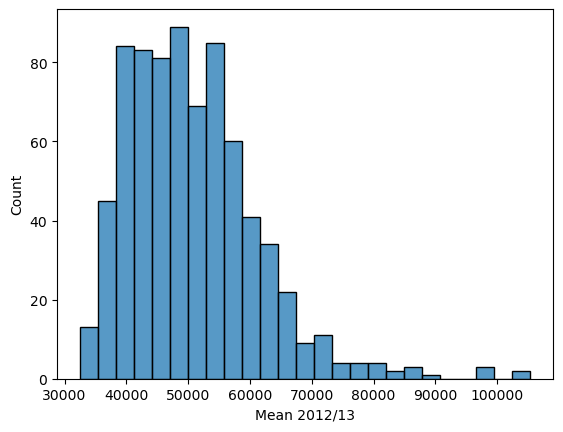

In [306]:
lsoa_income_df = lsoa_income_df[pd.to_numeric(lsoa_income_df['Mean 2012/13'], errors='coerce').notnull()]
lsoa_income_df['Mean 2012/13'] = lsoa_income_df['Mean 2012/13'].astype(float)
lsoa_income_df = lsoa_income_df.dropna(subset=['Mean 2012/13'])
sns.histplot(lsoa_income_df['Mean 2012/13'])
lsoa_income_df['Mean 2012/13'].describe()

In [307]:
lsoa_income_df['Mean 2012/13(log scale)']=np.log2(lsoa_income_df['Mean 2012/13'])

,area_id,weight,volume,f_energy_fat,f_energy_saturate,f_energy_sugar,f_energy_protein,f_energy_carb,f_energy_fibre,f_energy_alcohol,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,h_items_norm,representativeness_norm,Mean 2012/13,Median 2012/13,Mean 2012/13(log scale)
3,E01000005,356.033437,113.968805,0.443202,0.176424,0.226841,0.123545,0.404548,0.018140,0.010564,...,0.002717,0.154374,0.005047,0.028512,0.016832,0.781864,0.412036,71840.0,47840,16.132500
113,E01000117,377.937844,115.826696,0.446679,0.182002,0.225296,0.123159,0.404948,0.017111,0.008104,...,0.001861,0.165930,0.004915,0.020469,0.016146,0.783691,0.302320,51630.0,38580,15.655922
114,E01000118,382.240942,113.304149,0.448057,0.175092,0.228624,0.119338,0.405142,0.017502,0.009961,...,0.002855,0.159179,0.004834,0.027236,0.017133,0.789631,0.319172,52380.0,39090,15.676728
116,E01000120,370.002674,119.206474,0.442749,0.177979,0.242816,0.120013,0.411440,0.017481,0.008316,...,0.001637,0.171818,0.005950,0.023905,0.017100,0.771084,0.303055,58630.0,43200,15.839351
119,E01000123,389.783110,116.359711,0.461446,0.186599,0.211919,0.122899,0.388024,0.016987,0.010644,...,0.003783,0.144065,0.004533,0.026125,0.017602,0.794541,0.319601,50440.0,37770,15.622281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4790,E01033605,435.748190,135.306095,0.441468,0.177653,0.229577,0.114651,0.422803,0.015698,0.005380,...,0.001254,0.172335,0.006421,0.039355,0.012315,0.779397,0.313562,45520.0,27060,15.474213
4817,E01033731,334.776095,90.087677,0.463365,0.177805,0.206224,0.132039,0.373841,0.017621,0.013134,...,0.002604,0.130694,0.004867,0.024766,0.024935,0.811529,0.322312,51120.0,40450,15.641600
4819,E01033733,345.485958,96.633725,0.459192,0.182123,0.222108,0.117770,0.398567,0.017370,0.007100,...,0.002809,0.155098,0.004774,0.029776,0.014830,0.789645,0.305581,60130.0,46770,15.875797
4820,E01033734,331.705434,95.005281,0.465953,0.184817,0.210642,0.124566,0.378159,0.016858,0.014464,...,0.003725,0.144544,0.004550,0.026929,0.026405,0.816181,0.349960,49880.0,39540,15.606174


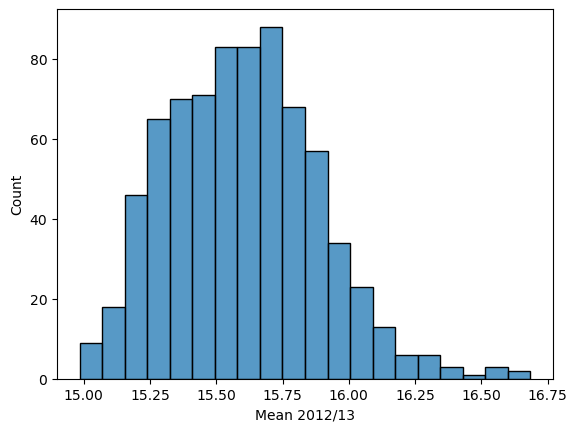

In [308]:
sns.histplot(np.log2(lsoa_income_df['Mean 2012/13']))
#lsoa_income_df=lsoa_income_df[lsoa_income_df['Mean 2012/13(log scale)']<17]
#lsoa_income_df[lsoa_income_df['Mean 2013/13(log scale)']>17.3]
lsoa_income_df

In [333]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [328]:
X=lsoa_income_df.iloc[:,1:26]
y=lsoa_income_df['Mean 2012/13(log scale)']
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=666,train_size=0.8)

In [319]:
def Train_LinearRegression(X_train,y_train,x_test,y_test):
    reg=LinearRegression()
    model=reg.fit(X_train,y_train)
    y_predict=reg.predict(x_test)
    residuals=y_test-y_predict
    print("Coef:",reg.coef_)
    print("RMSE:",np.sqrt(mean_squared_error(y_test,y_predict)))
    print("R2_scores:",r2_score(y_test,y_predict))
    return residuals

def Train_ridge(X_train,y_train,x_test,y_test):
    reg=Ridge(alpha=0.002)
    model=reg.fit(X_train,y_train)
    y_predict=reg.predict(x_test)
    residuals=y_test-y_predict
    print("Coef:",reg.coef_)
    print("RMSE:",np.sqrt(mean_squared_error(y_test,y_predict)))
    print("R2_scores:",r2_score(y_test,y_predict))
    return residuals

def Train_Lasso(X_train,y_train,x_test,y_test):
    reg=Lasso(alpha=0.00009)
    model=reg.fit(X_train,y_train)
    y_predict=reg.predict(x_test)
    residuals=y_test-y_predict
    print("Coef:",reg.coef_)
    print("RMSE:",np.sqrt(mean_squared_error(y_test,y_predict)))
    print("R2_scores:",r2_score(y_test,y_predict))
    return residuals

def Train_RF(X_train,y_train,x_test,y_test):
    rf= Rando(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svr_rbf.fit(X_train, y_train)
    y_predict = svr_rbf.predict(x_test)
    #print("Coef:",svr_rbf .coef_)
    residuals=y_test-y_predict
    print("RMSE:",np.sqrt(mean_squared_error(y_test,y_predict)))
    print("R2_scores:",r2_score(y_test,y_predict))


In [320]:
res1=Train_LinearRegression(x_train,y_train,x_test,y_test)

Coef: [-7.54408367e-04  1.31955122e-03  3.81180550e+09  6.93494835e+00
  2.49933873e-01  3.81180551e+09  3.81180550e+09  3.81180557e+09
  3.81180555e+09 -9.90909487e+00 -8.24346533e+00 -1.50519888e+00
 -3.92676987e+00  4.20046365e+00  3.30797920e-01  1.04286513e-01
 -7.29915440e+00  4.18123391e-01 -6.08244728e+00 -2.78476397e+01
  2.62196533e-01 -1.19600139e+01 -3.04837585e+00  4.47462238e+00
  3.59731112e-01]
RMSE: 0.11731865055679581
R2_scores: 0.7803555888867636
